# Лабораторная работа 2. Кластерный анализ данных

Задание:

Провести кластерный анализ набора данных своего варианта при помощи:

1. иерархической кластеризации;
2. метода k средних.

## Импорт необходимых библиотек

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import numpy as np
import random

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import rand_score
from sklearn.cluster import KMeans

In [5]:
from core.visualization import *

Для воспроизводимости экспериментов

In [6]:
random.seed(42)
np.random.seed(42)

## Загрузка и первичный анализ данных

In [7]:
data_path = 'data'

In [8]:
countries_df = pd.read_csv(f"{data_path}/zzz.csv", sep=';', encoding='utf-8')
countries_df.sample(10)

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион
62,Mongolia,36.1,8.8,68.0,60.0,62.5,110,5
40,Canada,14.5,7.3,7.2,73.0,79.8,20470,3
93,Tanzania,50.5,14.0,106.0,51.3,54.7,110,6
18,Paraguay,34.8,6.6,42.0,64.4,68.5,1110,2
81,Malawi,48.3,25.0,130.0,38.1,41.2,200,6
83,Mozambique,45.0,18.5,141.0,44.9,48.1,80,6
64,Pakistan,30.3,8.1,107.7,59.0,59.2,380,5
42,Afghanistan,40.4,18.7,181.6,41.0,42.0,168,5
10,Ukrainian_SSR,13.4,11.6,13.0,66.4,74.8,1320,1
0,Albania,24.7,5.7,30.8,69.6,75.5,600,1


Для улучшения читаемости добавим каждой записи текстовую метку региона, согласно описанию датасета

In [9]:
region_map = {
    1: 'Восточная Европа',
    2: 'Южная Америка и Мексика',
    3: 'Западная Европа, Северная Америка, Япония, Австралия, Новая Зеландия',
    4: 'Средний Восток',
    5: 'Азия',
    6: 'Африка'
}

In [10]:
countries_df['название_региона'] = countries_df['регион'].map(region_map)
countries_df.sample(10)

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион,название_региона
58,India,30.5,10.2,91.0,52.5,52.1,350,5,Азия
53,United_Arab_Emirates,22.8,3.8,26.0,68.6,72.9,19860,4,Средний Восток
90,Swaziland,46.8,12.5,118.0,42.9,49.5,810,6,Африка
86,Sierra_Leone,48.2,23.4,154.0,39.4,42.6,240,6,Африка
52,Turkey,29.2,8.4,76.0,62.5,65.8,1630,4,Средний Восток
57,Hong_Kong,11.7,4.9,6.1,74.3,80.1,14210,5,Азия
37,U.K.,13.6,11.5,8.4,72.2,77.9,16100,3,"Западная Европа, Северная Америка, Япония, Авс..."
15,Columbia,27.4,6.1,40.0,63.4,69.2,1260,2,Южная Америка и Мексика
59,Indonesia,28.6,9.4,75.0,58.5,62.0,570,5,Азия
23,Belgium,12.0,10.6,7.9,70.0,76.8,15540,3,"Западная Европа, Северная Америка, Япония, Авс..."


Проверим данные на наличие пропущенных значений

Согласно описанию датасета, в качестве метки пропущенного значения используется `-9999`. Найдем такие и проанализируем

Сначала заменим `-9999` на `NaN`

In [11]:
countries_df.replace(-9999, np.nan, inplace=True)

А после найдем эти значения средствами pandas

In [12]:
countries_df.isna().sum().sort_values(ascending=False)

доход               6
страна              0
рождаем             0
смертн              0
деск_см             0
длит_муж            0
длит_жен            0
регион              0
название_региона    0
dtype: int64

Как видно, пропуски есть только в столбце `доход`. Посмотрим на них

In [13]:
countries_df[np.isnan(countries_df['доход'])]

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион,название_региона
3,Former_E._Germany,12.0,12.4,7.6,69.8,75.9,NaN,1,Восточная Европа
7,Yugoslavia,14.0,9.0,20.2,68.6,74.5,NaN,1,Восточная Европа
49,Lebanon,31.7,8.7,48.0,63.1,67.0,NaN,4,Средний Восток
55,Cambodia,41.4,16.6,130.0,47.0,49.9,NaN,5,Азия
60,Korea,23.5,18.1,25.0,66.2,72.7,NaN,5,Азия
69,Vietnam,31.8,9.5,64.0,63.7,67.9,NaN,5,Азия


Как видно, страны, с пропусками в столбце `доход`, на момент составления датасета (1990 год) имели отличающиейся государственно-территориальные устройства от нынешних, либо вообще претерпели территориальные изменения

В данном случае мы не будем исключать их из анализа, а заменим значения дохода на средние по регионам, которым принадлежат эти страны

Создадим словарь со средними значениями дохода по регионам

In [14]:
mean_salary_map = countries_df.groupby('регион').agg(
    mean_salary=('доход', 'mean')
).to_dict()['mean_salary']

mean_salary_map

{1: 1931.3333333333333,
 2: 1672.5,
 3: 18706.0,
 4: 7392.0,
 5: 2332.0,
 6: 852.5925925925926}

Заменим пропущенные значения

In [15]:
countries_df['доход'] = countries_df.apply(
    lambda row: np.ceil(mean_salary_map[row['регион']]) if pd.isna(row['доход']) else row['доход'],
    axis=1
)

Проверим, что пропущенные значения отсутствуют

In [16]:
countries_df.isna().sum().sort_values(ascending=False)

страна              0
рождаем             0
смертн              0
деск_см             0
длит_муж            0
длит_жен            0
доход               0
регион              0
название_региона    0
dtype: int64

Посмотрим на представленные в датасете типы данных

In [17]:
countries_df.dtypes

страна               object
рождаем             float64
смертн              float64
деск_см             float64
длит_муж            float64
длит_жен            float64
доход               float64
регион                int64
название_региона     object
dtype: object

Видим, что датасет состоит преимущественно из числовых данных, исключениями являются строковые названия страны и регионов

Посмотрим описательные статистики числовых данных

In [18]:
countries_df.describe()

,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,29.229897,10.836082,54.901031,61.485567,66.151546,5574.288660,3.948454
std,13.546695,4.647495,45.992584,9.615970,11.005256,7879.033057,1.740277
min,9.700000,2.200000,4.500000,38.100000,41.200000,80.000000,1.000000
25%,14.500000,7.800000,13.100000,55.800000,57.500000,570.000000,3.000000
50%,29.000000,9.500000,43.000000,63.700000,67.800000,1932.000000,4.000000
75%,42.200000,12.500000,83.000000,68.600000,75.400000,7050.000000,6.000000
max,52.200000,25.000000,181.600000,75.900000,81.800000,34064.000000,6.000000


Видим, что столбец `доход` имеет другой порядок изменения, что может привести к излишней ориентированности алгоритмов кластеризации на данный показатель

Нормализуем значения столбца, поделив их на 1000. Тем самым, далее мы будем считать доход в тысячах долларов и приблизим порядок измерения столбца к остальным

In [19]:
countries_df['доход'] = countries_df['доход'] / 1000
countries_df.describe()

,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,29.229897,10.836082,54.901031,61.485567,66.151546,5.574289,3.948454
std,13.546695,4.647495,45.992584,9.615970,11.005256,7.879033,1.740277
min,9.700000,2.200000,4.500000,38.100000,41.200000,0.080000,1.000000
25%,14.500000,7.800000,13.100000,55.800000,57.500000,0.570000,3.000000
50%,29.000000,9.500000,43.000000,63.700000,67.800000,1.932000,4.000000
75%,42.200000,12.500000,83.000000,68.600000,75.400000,7.050000,6.000000
max,52.200000,25.000000,181.600000,75.900000,81.800000,34.064000,6.000000


Теперь порядки всех величин примерно одинаковый, можно продолжать кластерный анализ

## Визуальный кластерный анализ

Выберем цветовую палитру, с помощью которой будем различать регионы на графиках

In [20]:
palette = ['blue', 'green', 'purple', 'orange', 'magenta', 'brown']

Установим соответствие между столбцами датасета и их описаниями

In [21]:
columns_with_titles = {
    'доход': 'Совокупный национальный доход на душу населения в тысячах долларов США по странам',
    'рождаем': 'Количество рождений на 1,000 населения по странам',
    'смертн': 'Количество смертей на 1,000 населения по странам',
    'деск_см': 'Детская смертность (до 1 года ) на 1,000 населения по странам',
    'длит_муж': 'Ожидаемая длительность жизни на момент рождения для мужчин по странам',
    'длит_жен': 'Ожидаемая длительность жизни на момент рождения для женщин по странам'
}

Построим графики рассеяния, чтобы посмотреть связь между странами и разлчиными столбцами датасета

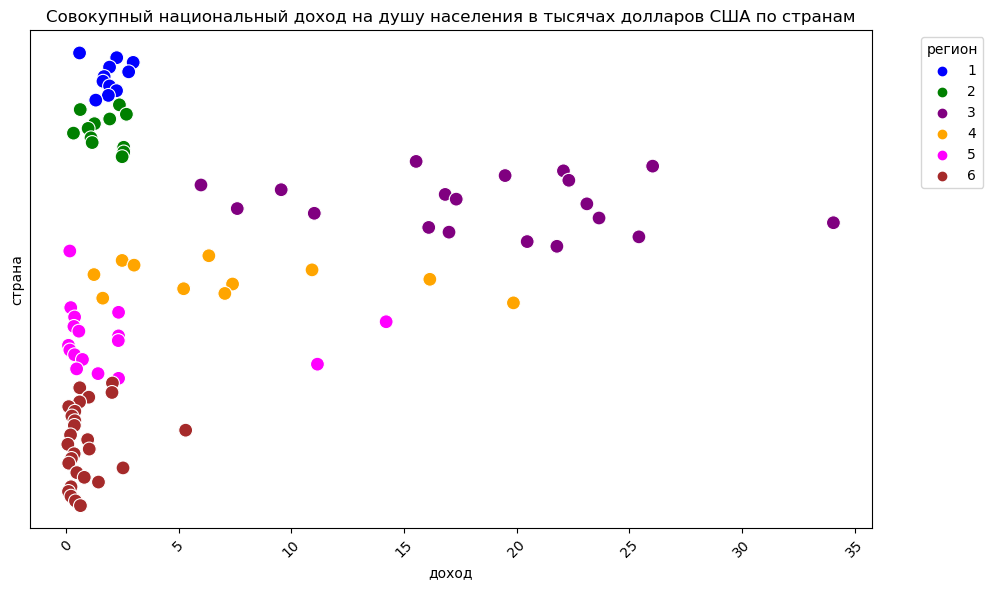

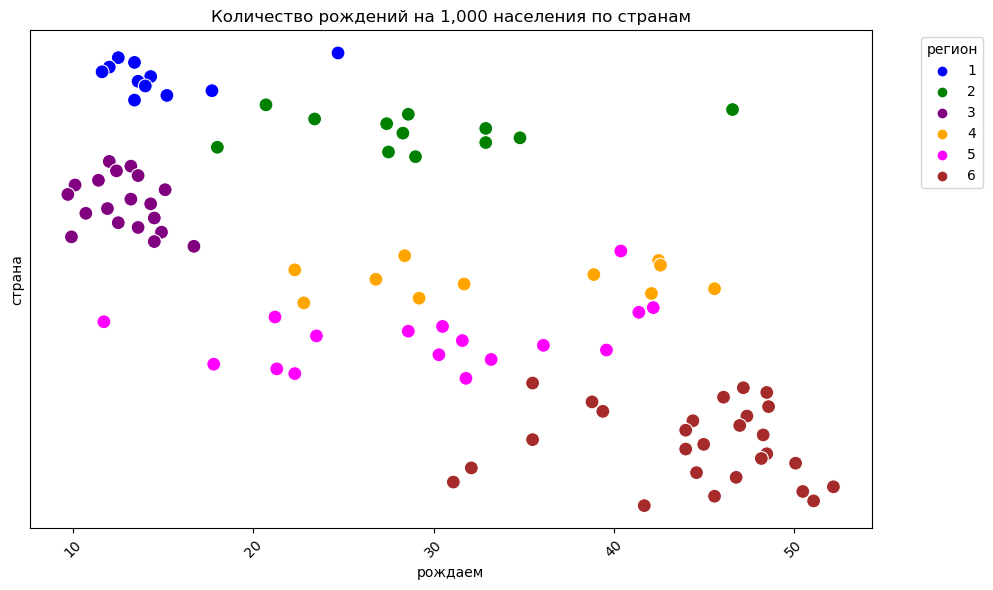

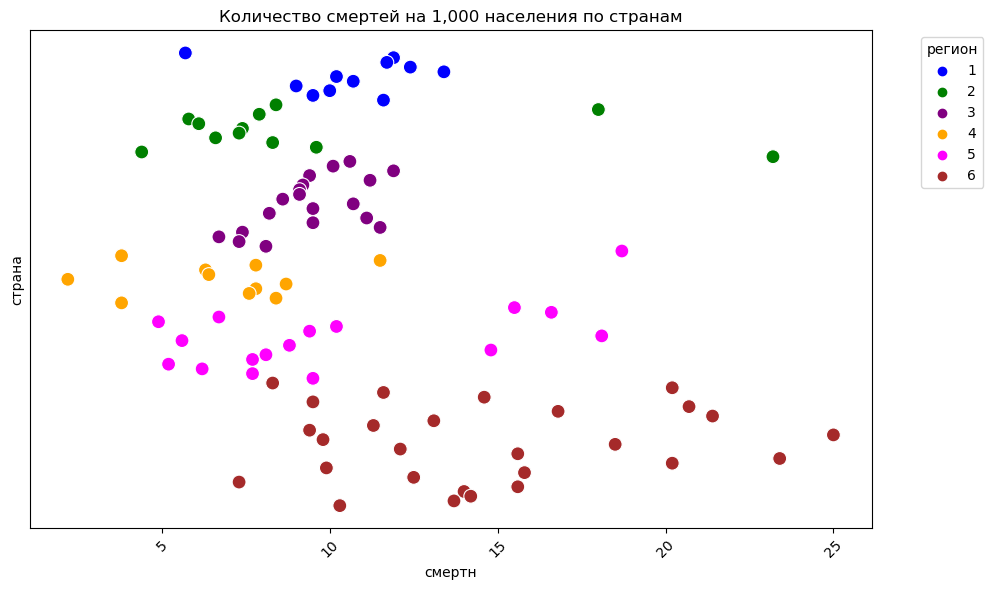

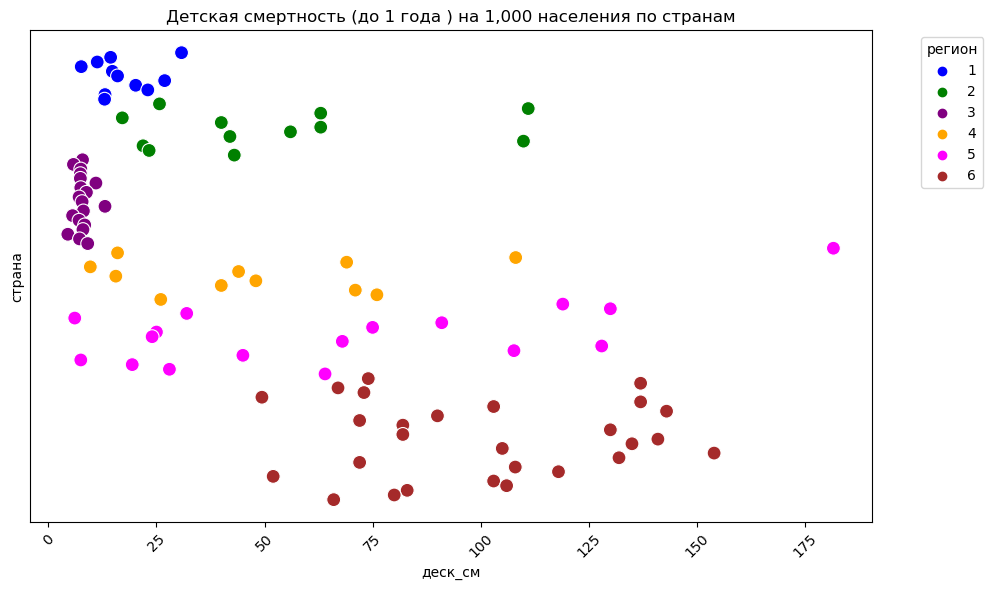

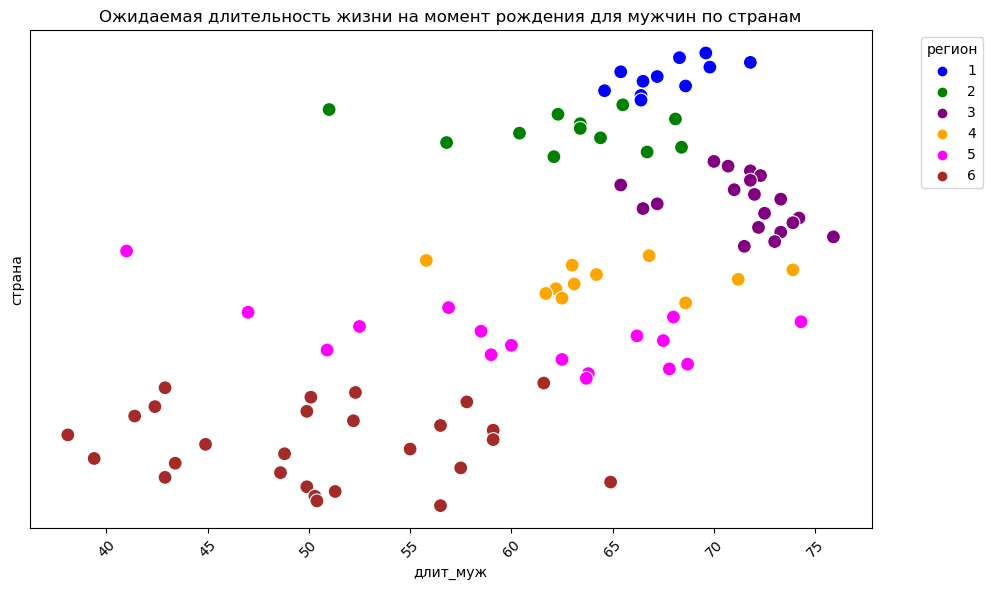

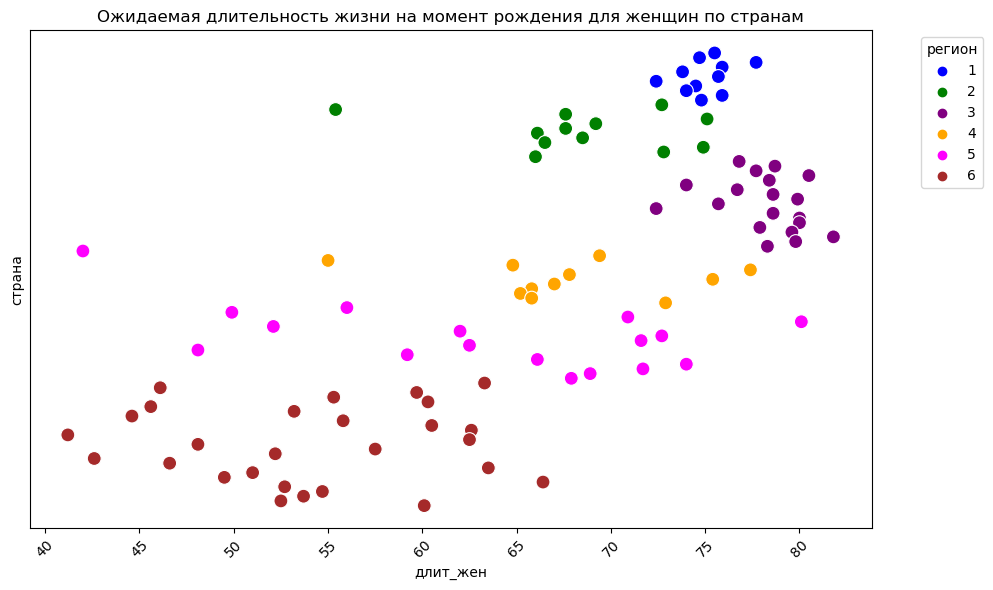

In [22]:
plot_scatters(data=countries_df, x_columns_with_titles=columns_with_titles, y='страна', color_column='регион', 
              palette=palette, hover_addition={'название_региона': True}, use_px=False)

На графике №1 в явный шарообразный кластер выделены страны Африки, общей чертой которых является низкий уровень дохода. 

Также практически в одном шарообразном кластере расположены страны Восточной Европы и Южной Америки, с также выделяющимся низким уровнем дохода. Это может свидетельствовать о том, что на момент создания датасета (1990 год) эти страны еще не получили достаточное экономическое развитие. 

Также можно наблюдать 2 ленточных кластера - страны Среднего Востока и "Глобального" Запада. Такое поведение может быть связано с большой разницей в техническом прогрессе между странами и типами хозяйства. 

Можно заметить кластер стран с низким доходом - страны Азии, где "выбросами" являются Сингапур и Гонконг. Низкий уровень дохода на жителя в большинстве этих стран связан с большим количеством населения в них и низкой технологизации для некоторых, это подтверждает и расположение стран-выбросов, у которых достаточно низкое количество населения 

На графике №2 мы видим 2 выделенных кластера европейских и западных стран с низкой рождаемостью, при учете страны-выброса Албании. Такое поведение может быть связано с исламом как преобладающей религией в этой стране.

Можно отметить ленточный кластер африканских стран с высокой рождаемостью, расположенный в правой половине графика.

Примерно одинаковы ленточные кластеры стран Азии, Среднего Востока и Южной Америки. Они занимают место примерно в центре графика

На графике №3 видно 2 длинных ленточных класетра - страны Африки и Азии, демонстрирующие сравнительно высокие показатели смертности. Наименьшую смертность из африканских стран имеет Тунис, что, на контрасте с низкой рождаемостью, говорит о сравнительно низком числе населения.

Низкую смертность показывают страны Среднего Востока, Восточной Европы и Южной Америки (за исключением страны-выброса Мексики). Все эти регионы формируют ленточные кластеры.

Относительно шарообразный кластер, группирующийся в районе средних значений смертности образуют страны "Глобального" Запада

На графике №4 мы видим практически шарообразный кластер стран "Глобального" Запада с крайне низкой детской смертностью, что обусловлено высоким уровнем медицины в этих странах. Также достаточно низкая детская смертность наблюдается в странах Восточной Европы.

Примерно одинаково распределены страны Азии и Среднего Востока, представляя собой длинные ленточные кластеры. На такое распределение может влиять разница в количестве населения в целом, а также большая разница по уровню технологизации. Большим выбросом является Афганистан, высокая детская смертность в нем может быть следствием большого числа войн на момент составления датасета

Графики 5 и 6 практически идентичны, поэтому рассмотрим их вместе. Страны Азии и Африки представлены длинными ленточными кластерами, антирекорд демонстрирует Афганистан (что связано с военными действиями) и Малави со Сьерра-Леоне, что говорит о низком уровне жизни в этих странах.

Страны Среднего Востока и Южной Америки образуют ленточный кластер, расположенный преимущественно в правой половине графика. Выбросами в сторону низкой ожидаемой продолжительности жизни является Боливия.

Шарообразные кластеры с высокой ожидаемой продолжительностью жизни образуют страны "Глобального" Запада и Восточной Европы, что может быть следствием достаточно высокого уровня медицины и технологизации в них

Проанализируем важность столбцов для использования при работе алгоритма кластеризации

Удалим целевые столбцы

In [23]:
cluster_analysis_df = countries_df.copy()
cluster_analysis_df.drop(columns=['регион', 'название_региона'], axis=1, inplace=True)
cluster_analysis_df.sample(10)

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход
33,Portugal,11.9,9.5,13.1,66.5,72.4,7.600
9,Byelorussian_SSR,15.2,9.5,13.1,66.4,75.9,1.880
44,Iran,42.5,11.5,108.1,55.8,55.0,2.490
12,Bolivia,46.6,18.0,111.0,51.0,55.4,0.630
20,Uruguay,18.0,9.6,21.9,68.4,74.9,2.560
26,France,13.6,9.4,7.4,72.3,80.5,19.490
57,Hong_Kong,11.7,4.9,6.1,74.3,80.1,14.210
50,Oman,45.6,7.8,40.0,62.2,65.8,5.220
61,Malaysia,31.6,5.6,24.0,67.5,71.6,2.320
42,Afghanistan,40.4,18.7,181.6,41.0,42.0,0.168


In [24]:
cluster_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   страна    97 non-null     object 
 1   рождаем   97 non-null     float64
 2   смертн    97 non-null     float64
 3   деск_см   97 non-null     float64
 4   длит_муж  97 non-null     float64
 5   длит_жен  97 non-null     float64
 6   доход     97 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.4+ KB


Проанализируем корреляции между числовыми переменными

In [25]:
correlations = cluster_analysis_df.select_dtypes(include='float').corr()

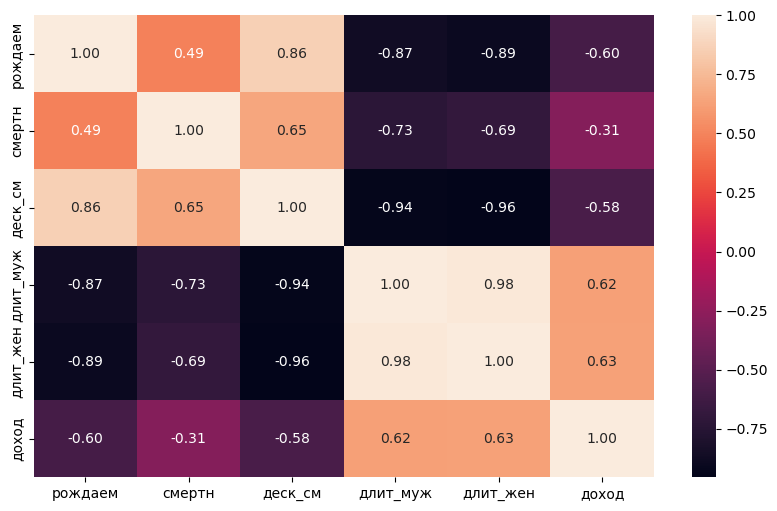

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

Как видно, многие переменные зависят друг от друга почти функционально, однако глобально все они могут быть полезными для процедуры кластеризации, поэтому использоваться будут все

In [27]:
columns_to_cluster = ['доход', 'рождаем', 'смертн', 'деск_см', 'длит_муж', 'длит_жен']

Визуализируем исходные кластеры по переменной `регион` с помощью многомерного шкалирования

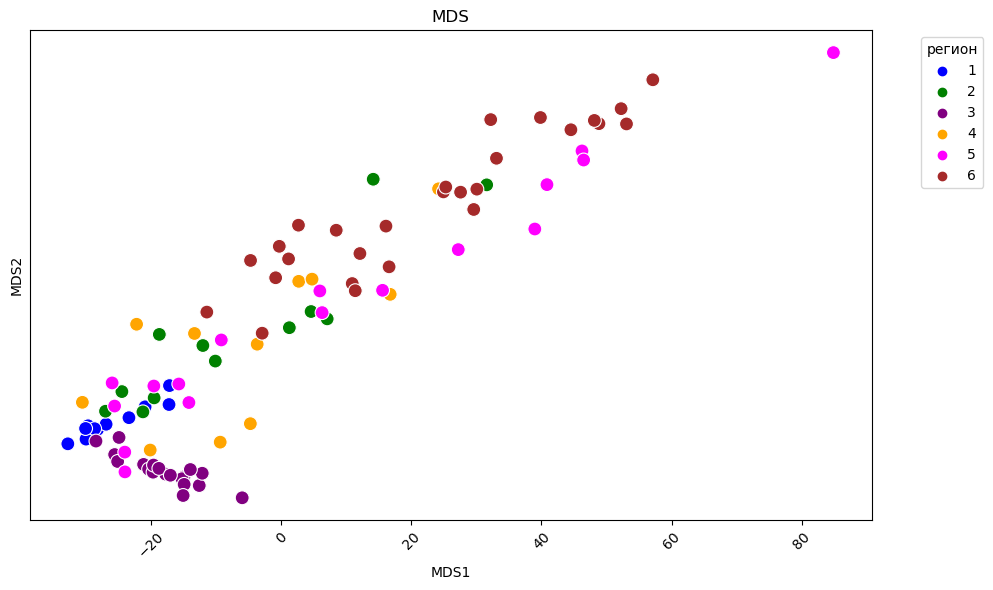

In [28]:
plot_using_mds(data=countries_df, valuable_columns=columns_to_cluster, n_components=2, hover_name='страна', 
               title='MDS', color_column='регион',
               hover_addition={'название_региона': True}, palette=palette, random_state=42, use_px=False)

При отображении с помощью MDS мы видим небольшой сгруппированный кластер стран "Глобального" Запада, а также страну-выброс Афганистан, чье расположение на графике может быть обусловленно описанными выше следствиями военных действий.

Можно выделить ленточный кластер стран Африки, характерной общей чертой которых является относительно низкий уровень жизни.

Остальные страны не имеют четкой взаимосвязи по регионам, поэтому рассмотрим предлагаемые иерархическим методом и методом k средних кластеризации

## Иерархическая кластеризация

Проведем иерархическую кластеризацию методов Уорда, поскольку диаграммы рассеивания показывали ярко выраженные шаровидные скопления и менее явные ленточные. Метод позволит обособить эти шаровидные скопления, а также на определенном уровне выделит и ленточные кластеры

In [29]:
hierarchy_clusters = linkage(cluster_analysis_df[columns_to_cluster], method='ward')

Визуализируем результат с помощью дендрограммы

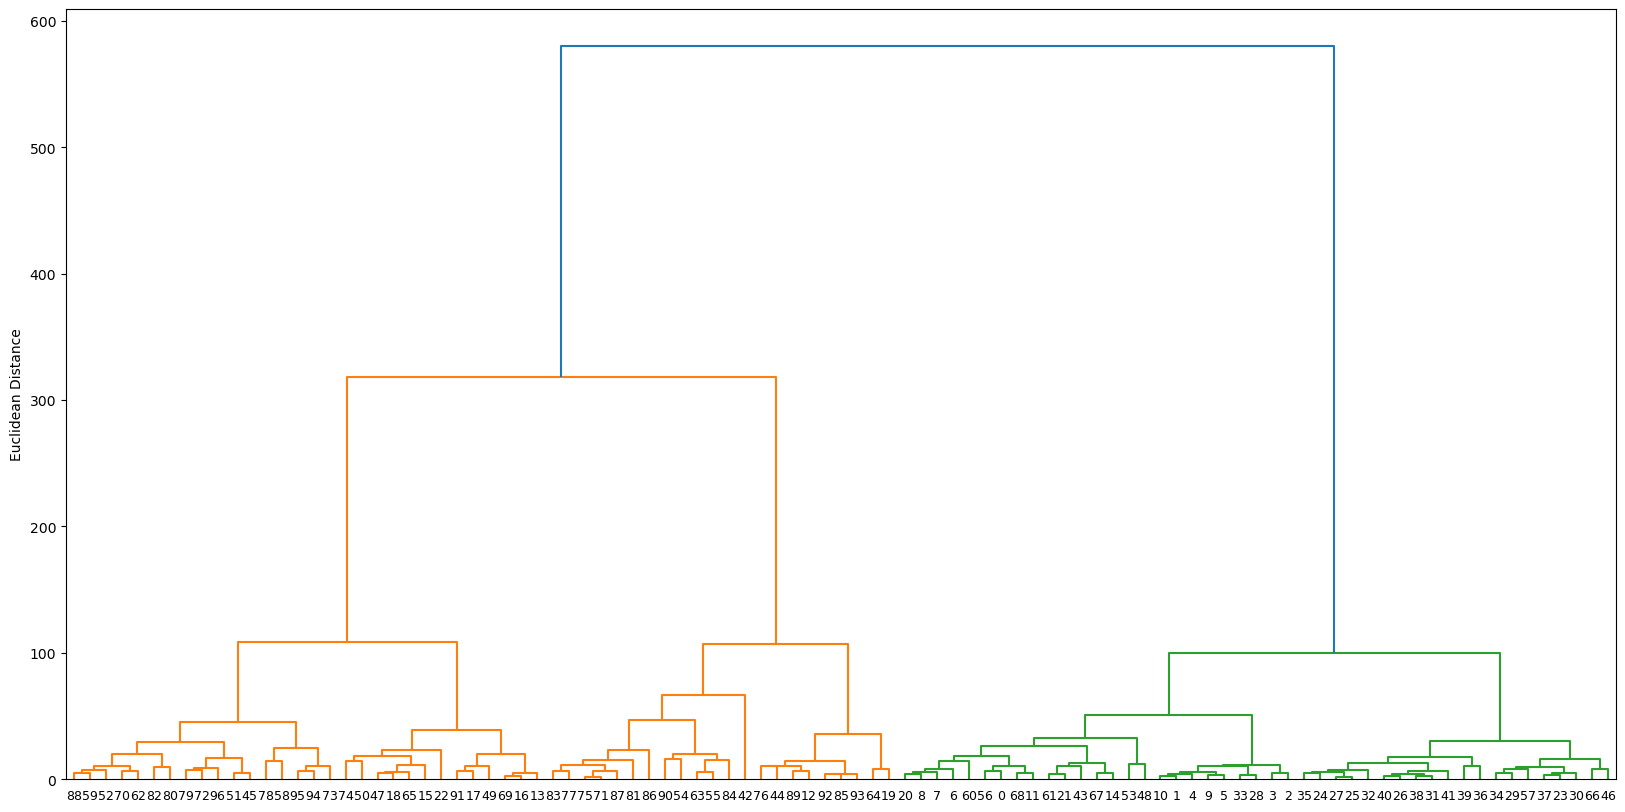

In [30]:
plt.figure(figsize=(20, 10))
dendrogram(hierarchy_clusters, labels=cluster_analysis_df[columns_to_cluster].index.tolist(), distance_sort='descending', 
           show_leaf_counts=True, leaf_font_size=9, leaf_rotation=360)
plt.ylabel('Euclidean Distance')
plt.show()

На дендрограмме видно, что наиболее адекватным выглядит разделение на 6 кластеров, поскольку далее начинается излишняя детализация и уменьшение расстояния между кластерами становится менее ощутимым

Из этого можно сделать вывод, что оптимальным является выделение 6-ти кластеров, проверим это с помощью графика "каменистая осыпь"

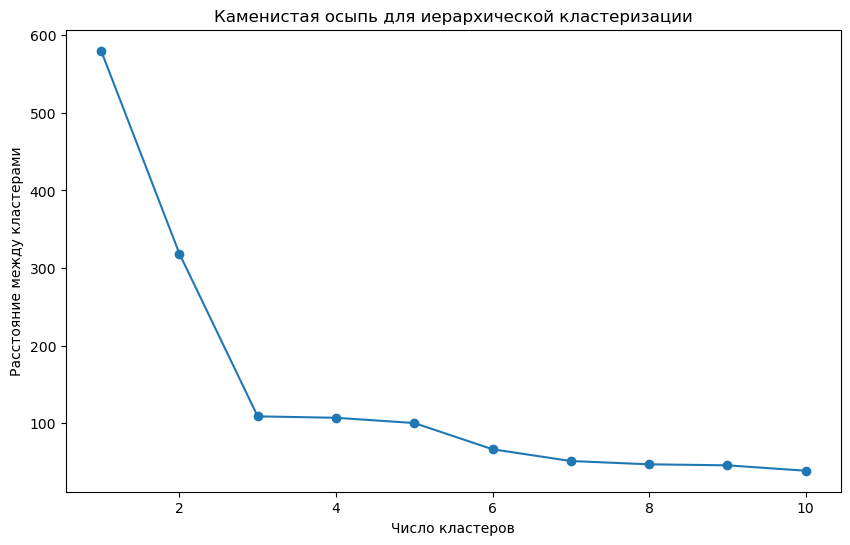

In [31]:
last = hierarchy_clusters[-10:, 2]
num_clusters = range(1, len(last) + 1)

plt.figure(figsize=(10, 6))
plt.plot(num_clusters, last[::-1], marker='o')
plt.title('Каменистая осыпь для иерархической кластеризации')
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние между кластерами')
plt.show()

Как видно из графика, последнее ощутимое уменьшение расстояния между кластерами видно при переходе от 5 к 6 кластерам. Поэтому опитмальным решением будет выделить именно 6 кластеров (что, также, совпадает с количеством регионов в датасете)

Выделим эти 6 кластеров 

In [32]:
n_clusters = 6
hierarchy_clusters = fcluster(hierarchy_clusters, n_clusters, criterion='maxclust')
hierarchy_clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 5, 5, 5, 5, 3, 2, 2,
       5, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2,
       3, 6, 1, 5, 2, 5, 5, 6, 6, 2, 4, 4, 2, 1, 6, 6, 2, 2, 6, 4, 3, 5,
       1, 2, 2, 5, 6, 4, 6, 6, 5, 4, 3, 4, 6, 6, 6, 4, 6, 4, 4, 3, 4, 4,
       6, 3, 4, 5, 3, 3, 6, 6, 6], dtype=int32)

В переменной `hierarchy_clusters` содержится список кластерных меток для каждой страны из датасета. Создадим новый датафрейм, в который будем записывать получаемые кластерные метки с помощью различных алгоритмов кластеризации

In [33]:
clustered_df = countries_df.copy()
clustered_df['hierarchy_cluster'] = hierarchy_clusters
clustered_df.sample(10)

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион,название_региона,hierarchy_cluster
4,Hungary,11.6,13.4,14.8,65.4,73.8,2.780,1,Восточная Европа,2
11,Argentina,20.7,8.4,25.7,65.5,72.7,2.370,2,Южная Америка и Мексика,2
46,Israel,22.3,6.3,9.7,73.9,77.4,10.920,4,Средний Восток,1
55,Cambodia,41.4,16.6,130.0,47.0,49.9,2.332,5,Азия,4
57,Hong_Kong,11.7,4.9,6.1,74.3,80.1,14.210,5,Азия,1
39,Japan,9.9,6.7,4.5,75.9,81.8,25.430,3,"Западная Европа, Северная Америка, Япония, Авс...",1
13,Brazil,28.6,7.9,63.0,62.3,67.6,2.680,2,Южная Америка и Мексика,5
51,Saudi_Arabia,42.1,7.6,71.0,61.7,65.2,7.050,4,Средний Восток,6
86,Sierra_Leone,48.2,23.4,154.0,39.4,42.6,0.240,6,Африка,4
94,Zaire,45.6,14.2,83.0,50.3,53.7,0.220,6,Африка,6


Визуализируем исходные кластеры по переменной `hierarchy_cluster` с помощью многомерного шкалирования

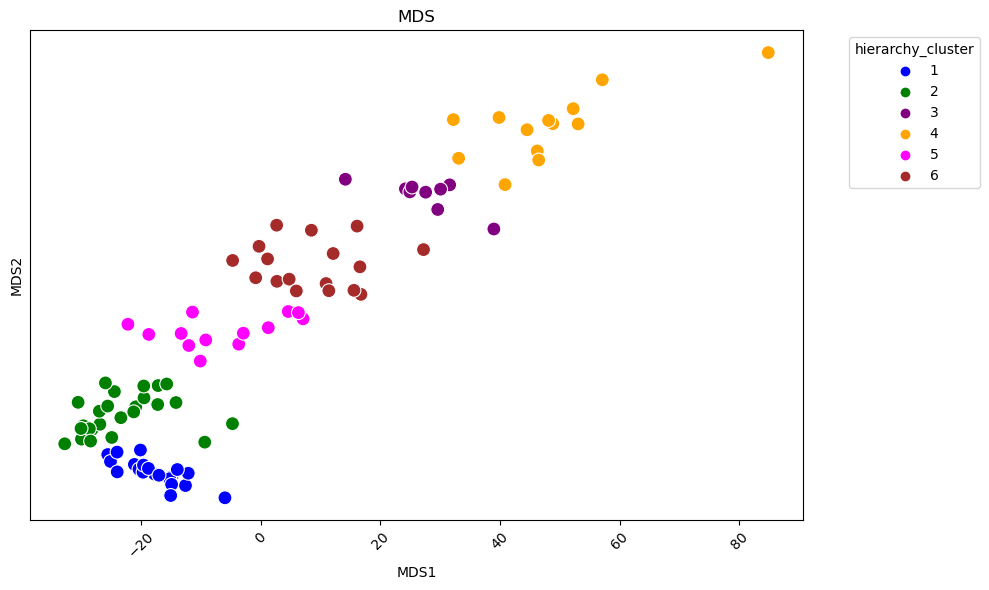

In [34]:
plot_using_mds(data=clustered_df, valuable_columns=columns_to_cluster, n_components=2, hover_name='страна', 
               title='MDS', color_column='hierarchy_cluster',
               hover_addition={'название_региона': True}, palette=palette, random_state=42, use_px=False)

На графике видно, что иерархическая кластеризация объединила Афганистан с бедными странами Африки, что может говорить о том, что кластер с меткой 4 представляет страны с низким уровнем жизни.

Также в один кластер с меткой 6 попали почти одни страны Африки вместе с Индией, Монголией и Ираком. Можно предположить, что эти страны объединяет расположение в южных регионах с вытекающими климатическими особенностями, и примерно одинаковый уровень жизни.

В один кластер был сведен ряд стран "Глобального" Запада и Гонконг, их объединяет достаточно высокий уровень жизни (можно вспомнить что Гонконг был выбросом для стран Азии по ряду показателей).

Близко к ним расположен кластер стран, характерной чертой которых может служить устрой, близкий к коммунистическому. Уровень жизни в этих странах сопоставим с капиталистическими странами из кластера 1.

Примерно одинаковый уровень жизни и у стран в кластерах 5 и 3

Если посмотреть на полученный график глобально, то можно заметить, что в нижней его части расположены страны с высоким уровнем жизни и по мере движение вверх и вправо - уровень жизни в соответствтующих странах все ниже и ниже. Исходя из этого можно сделать вывод, что как кластеризатор, так и алгоритм многомерного шкалирования смогли агрегировать предложенные характеристики в совокупный "уровень жизни" и разделить объекты по этому критерию 

Построим графики рассеяния, чтобы посмотреть связь между странами и разлчиными столбцами датасета с учетом новых кластеров

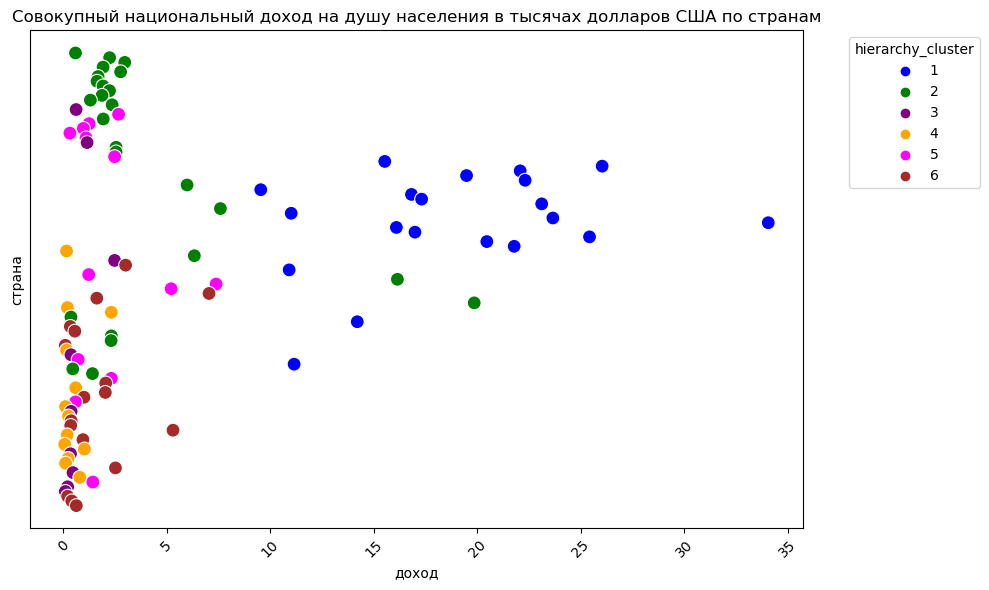

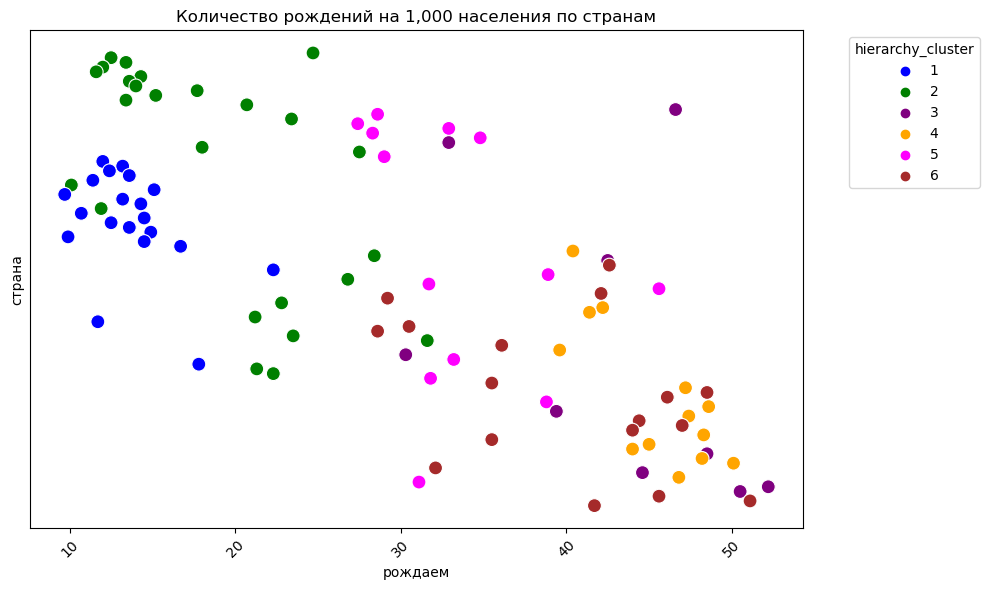

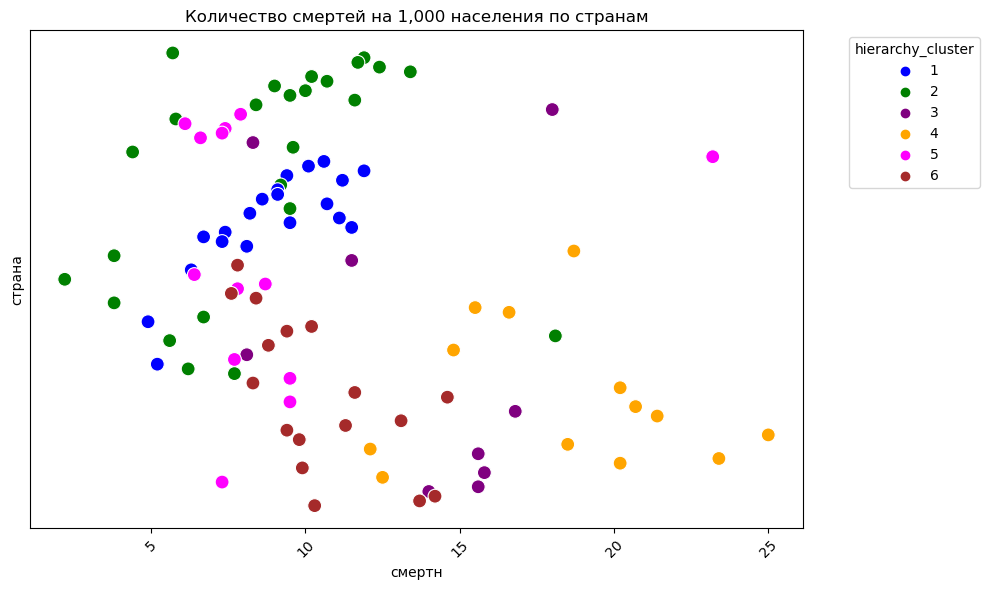

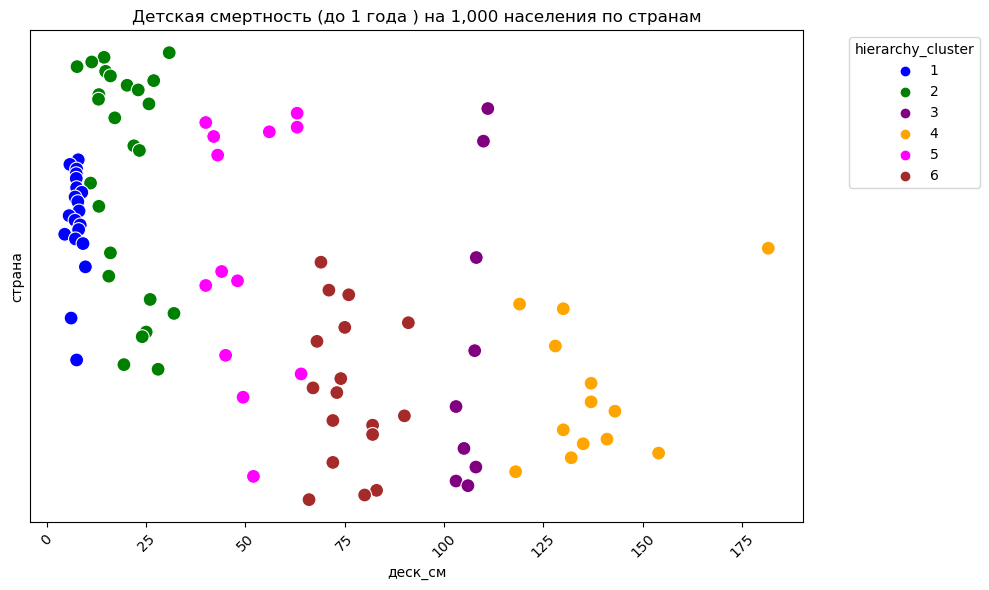

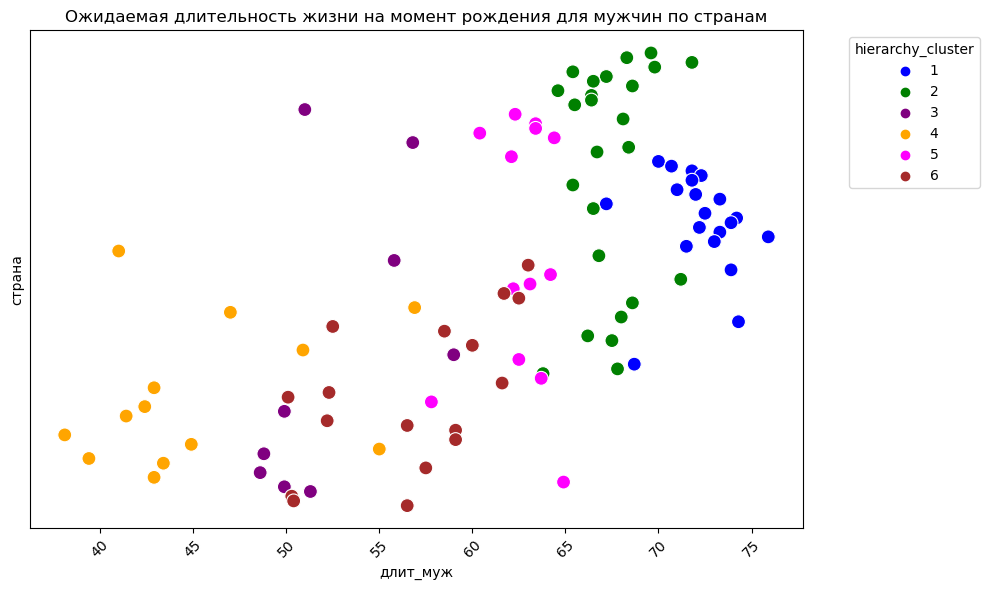

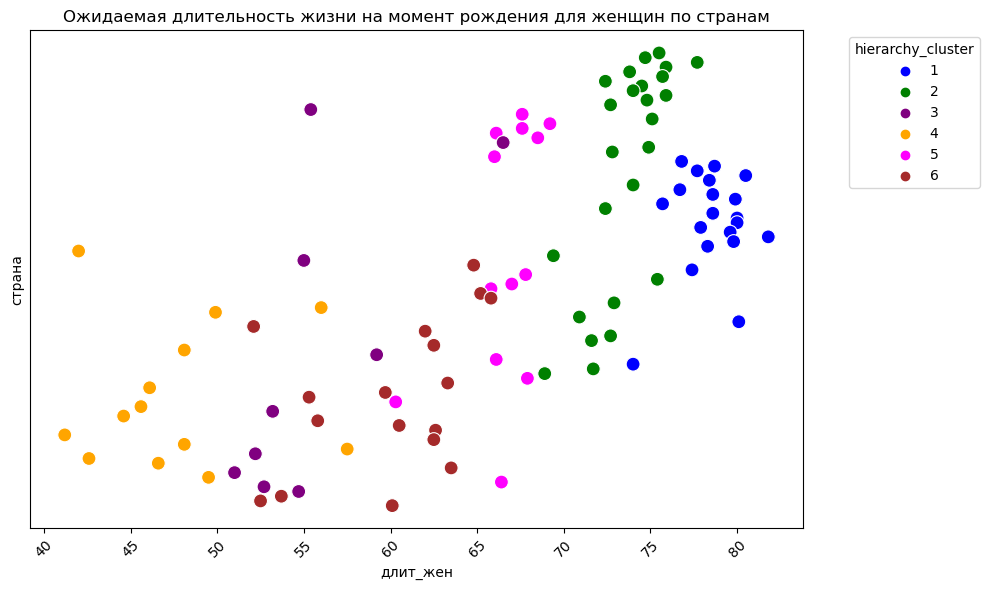

In [35]:
plot_scatters(data=clustered_df, x_columns_with_titles=columns_with_titles, y='страна', 
              color_column='hierarchy_cluster', 
              palette=palette, hover_addition={'название_региона': True}, use_px=False)

Наиболее успешно выделение ленточные кластеры описывают детскую смертность (график №4), что говорит о высокой значимости детской смертности как метрики, определяющей благосостояние страны, что соответствует здравому смыслу.

Также достаточно хорошо выделенные ленточные и несколько шаровидных кластеров описывают ожидаемую продолжительность жизни.

Чуть менее качественно кластеры отражают рождаемость и смертность в странах и еще хуже - доходы. Последнее может говорить о слишком маленьком выбранном масштабирующем коэффициенте (0.001), уменьшившим значимость данной метрики  

Проверим качество кластеризации с помощью метрики [rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html)

Выделим верные и полученные после иерархической кластеризации метки 

In [36]:
labels = clustered_df['регион']
labels

0     1
1     1
2     1
3     1
4     1
     ..
92    6
93    6
94    6
95    6
96    6
Name: регион, Length: 97, dtype: int64

In [37]:
preds = clustered_df['hierarchy_cluster']
preds

0     2
1     2
2     2
3     2
4     2
     ..
92    3
93    3
94    6
95    6
96    6
Name: hierarchy_cluster, Length: 97, dtype: int32

Вычислим `rand_score`

In [38]:
rand_score(labels_pred=preds, labels_true=labels)

0.7938144329896907

Результат практически равен `0.8`, что говорит о достаточно высоком качестве кластеризации

## Кластеризация с помощью метода k средних

На предыдущем шаге мы выяснили, что оптимальным число кластеров является 6, что совпало с количеством регионов в датасете. Попробуем также выделить 6 кластеров методом k средних

In [39]:
kmean_set = {'init':'random', 'n_init': 10, 'random_state': 42}

In [40]:
kmeans = KMeans(n_clusters=n_clusters, **kmean_set)

In [41]:
kmeans.fit(cluster_analysis_df[columns_to_cluster])
kmeans_labels = kmeans.labels_ + 1 # по умолчанию отсчет начинается с 0
kmeans_labels

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 4, 2, 6, 2, 2, 5, 4, 4,
       2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4,
       5, 6, 3, 2, 3, 2, 2, 6, 6, 4, 5, 1, 4, 3, 5, 6, 4, 4, 6, 1, 5, 2,
       3, 4, 4, 6, 6, 1, 6, 6, 2, 1, 5, 1, 5, 6, 6, 1, 6, 1, 1, 5, 1, 1,
       6, 5, 5, 2, 5, 5, 6, 6, 6])

Добавим к датафрейму столбец с номерами кластеров, полученными методом k средних

In [42]:
clustered_df['kmeans_cluster'] = kmeans_labels
clustered_df.sample(10)

,страна,рождаем,смертн,деск_см,длит_муж,длит_жен,доход,регион,название_региона,hierarchy_cluster,kmeans_cluster
23,Belgium,12.0,10.6,7.9,70.0,76.8,15.540,3,"Западная Европа, Северная Америка, Япония, Авс...",1,3
60,Korea,23.5,18.1,25.0,66.2,72.7,2.332,5,Азия,2,4
17,Guyana,28.3,7.3,56.0,60.4,66.1,0.330,2,Южная Америка и Мексика,5,2
68,Thailand,22.3,7.7,28.0,63.8,68.9,1.420,5,Азия,2,4
37,U.K.,13.6,11.5,8.4,72.2,77.9,16.100,3,"Западная Европа, Северная Америка, Япония, Авс...",1,3
79,Kenya,47.0,11.3,72.0,56.5,60.5,0.370,6,Африка,6,6
26,France,13.6,9.4,7.4,72.3,80.5,19.490,3,"Западная Европа, Северная Америка, Япония, Авс...",1,3
86,Sierra_Leone,48.2,23.4,154.0,39.4,42.6,0.240,6,Африка,4,1
10,Ukrainian_SSR,13.4,11.6,13.0,66.4,74.8,1.320,1,Восточная Европа,2,4
1,Bulgaria,12.5,11.9,14.4,68.3,74.7,2.250,1,Восточная Европа,2,4


Визуализируем исходные кластеры по переменной `kmeans_cluster` с помощью многомерного шкалирования

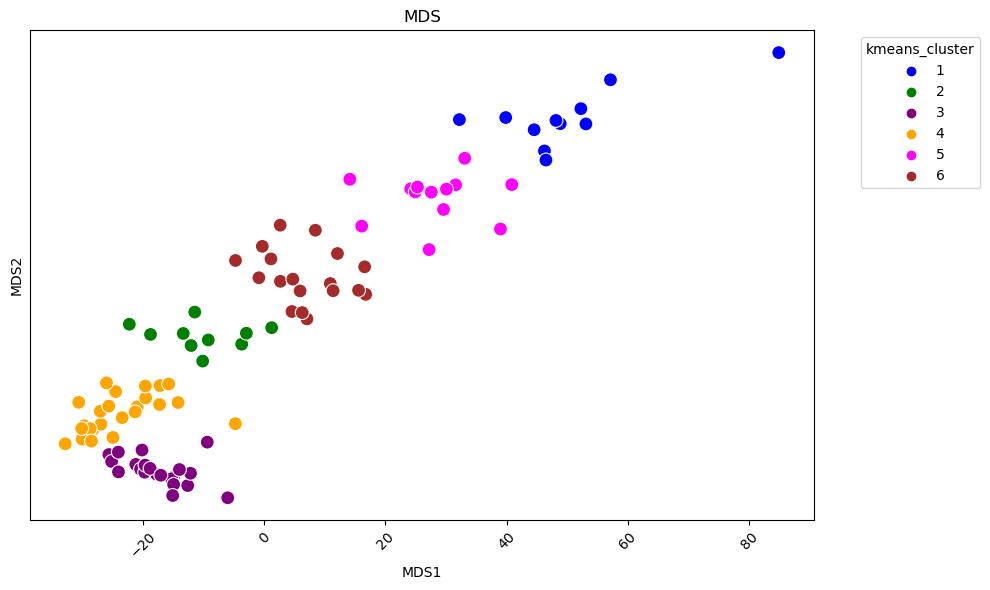

In [43]:
plot_using_mds(data=clustered_df, valuable_columns=columns_to_cluster, n_components=2, hover_name='страна', 
               title='MDS', color_column='kmeans_cluster',
               hover_addition={'название_региона': True, 'регион': True}, palette=palette, random_state=42, use_px=False)

Результат кластеризации очень похож на то, что мы видели при иерархической кластеризации, разница только в перераспределении граничных значений по кластерам.

Так, Кувейт перешел в кластер капиталистических стран с самым высоким уровнем жизни (согласно распределению полученному с помощью MDS). Также Бразилия, Вьетнам и Эквадор перешли в один кластер с африканскими странами с самым благоприятным уровнем жизни для своего региона.

Можно заметить что 2 кластера стран с самым низким уровнем жизни перебалансировались и число стран с самым низким уменьшилось

Однако глобально, кластеры очень похожи друг на друга, поэтому сравним качество кластеризации методом k средних с иерархической с помощью метрики `rand_score`

In [44]:
rand_score(labels_pred=kmeans_labels, labels_true=labels)

0.7867268041237113

Как видно, метрики отличаются примерно на `0.007` что говорит о почти полной идентичности полученных кластеров

Построим графики рассеяния, чтобы посмотреть связь между странами и разлчиными столбцами датасета с учетом кластеров, полученных методом k средних

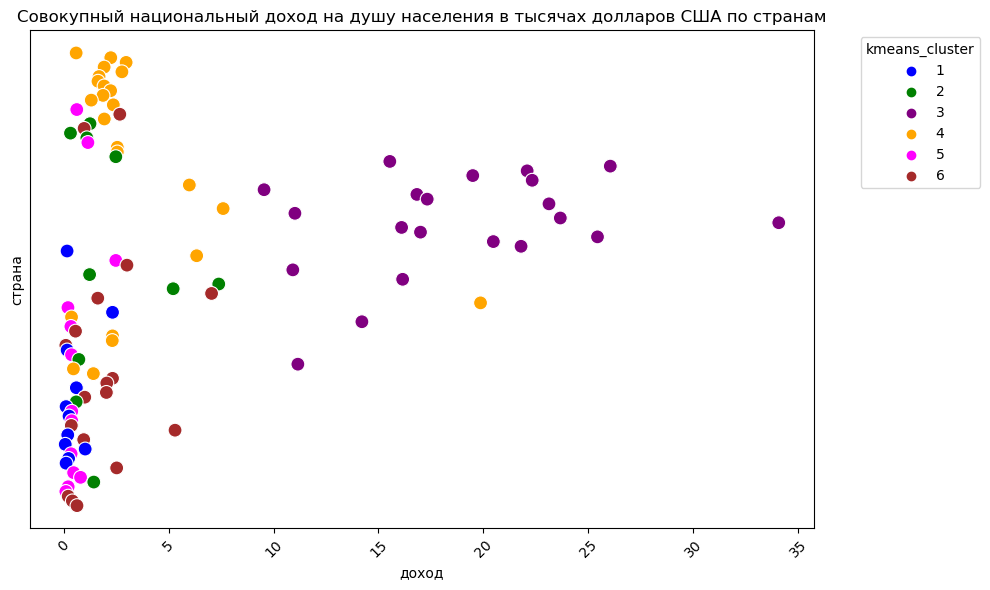

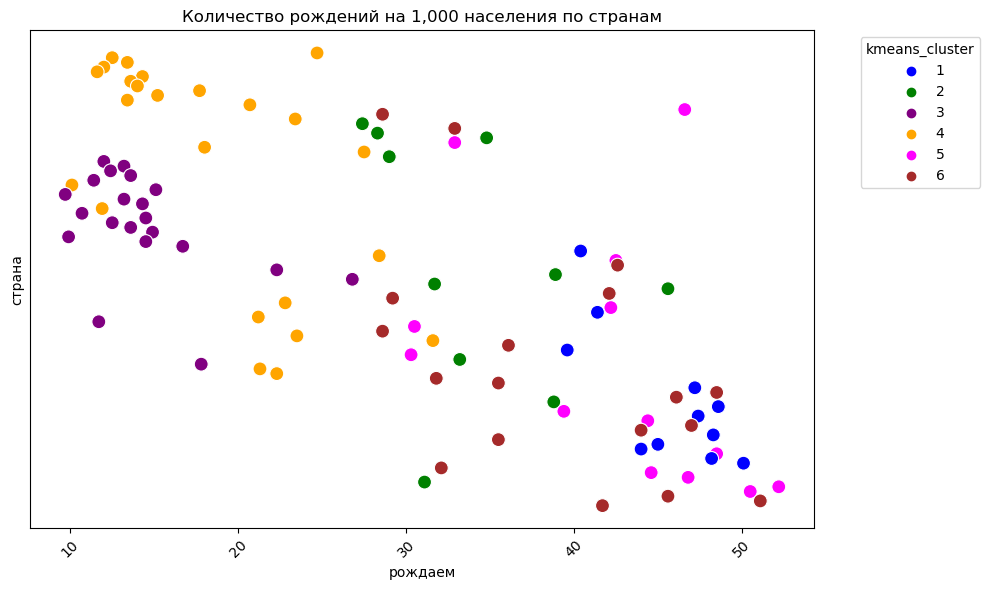

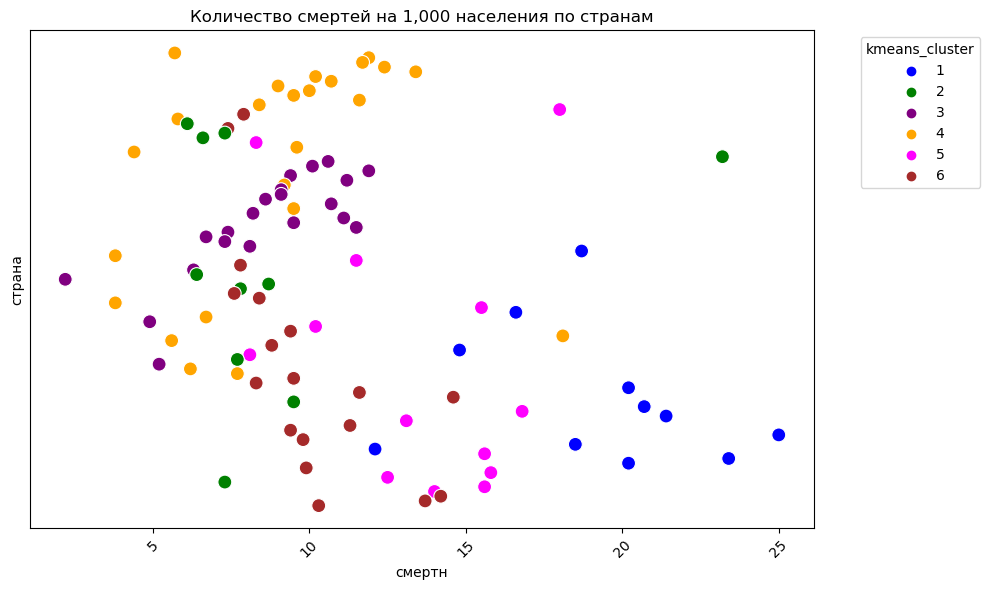

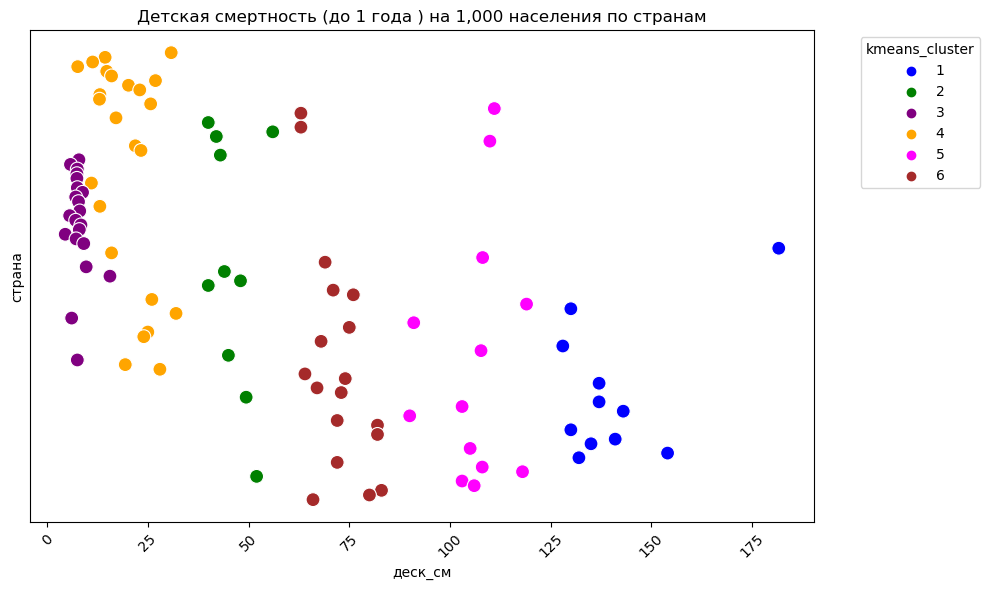

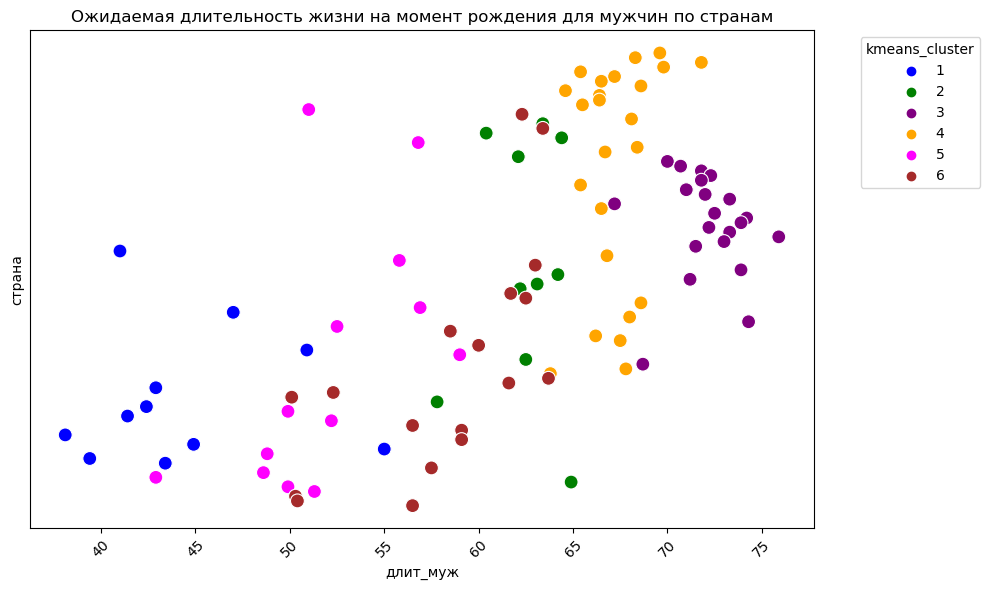

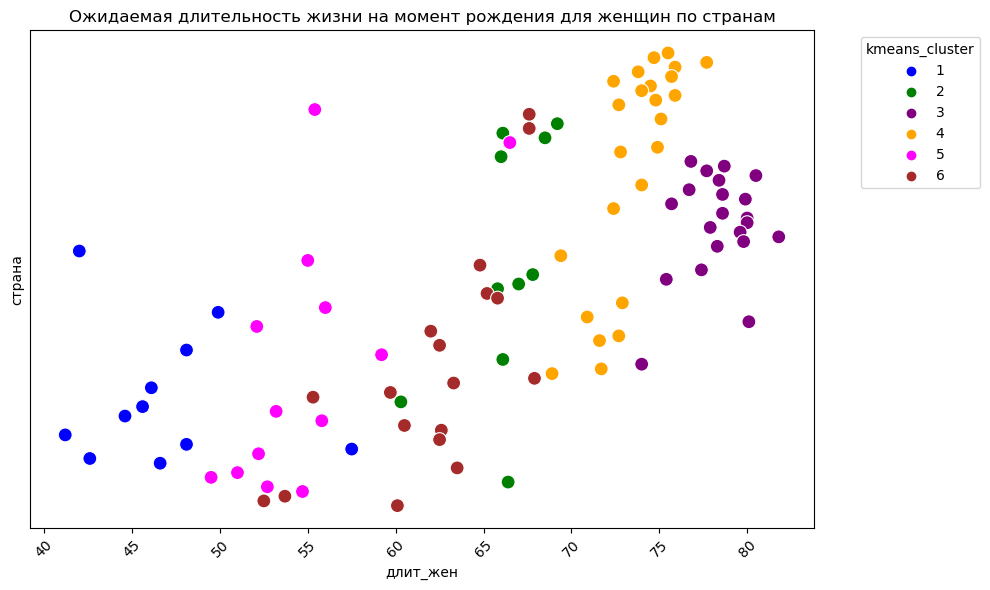

In [45]:
plot_scatters(data=clustered_df, x_columns_with_titles=columns_with_titles, y='страна', 
              color_column='kmeans_cluster', 
              palette=palette, hover_addition={'название_региона': True}, use_px=False)

Полученные графики схожи с графиками, в которых представлено описание числовых столбцов датасета иерархически полученными кластерами, описанными выше

## Заключение

Посмотрим, насколько близки между собой кластеры, полученные рассмотренными методами

In [46]:
rand_score(labels_pred=kmeans_labels, labels_true=preds)

0.9546821305841925

Такое близкое сходство может говорить о том, что данные обладают достаточной кластеризуемостью и все представленные features датасета могут описать глобальный уровень жизни в каждой стране и разбить данные на кластеры по нему

Подобное разбиение может быть полезно в области международной маркетологии (продвижение товаров и пр.) а также при составлении ценовой политики в отношении каждой из стран